# Measuring performances of sklearn tools in classifying astroparticles detected by Cherenkov telescopes

## The scientific context
Gamma ray astronomy is the astronomical observation of gamma rays, the most energetic form of electromagnetic radiation, with photon energies above 100 keV. Radiation below 100 keV is classified as X-rays and is the subject of X-ray astronomy.

Ground-based gamma-ray astronomy is a young field with enormous scientific potential. The current generation instruments H.E.S.S., MAGIC and VERITAS have already demonstrated the huge physical potential of astrophysical measurements at teralectronvolt (TeV) energies. The 150+ sources detected by these instruments, and the wide range of high impact scientific results, suggest that particle acceleration is common in nature, and that the known objects are just the tip of the iceberg.

Building on the technology of current generation ground-based gamma-ray detectors (H.E.S.S., VERITAS and MAGIC), **CTA** will be ten times more sensitive and have unprecedented accuracy in its detection of high-energy gamma rays. Current gamma-ray telescope arrays host up to five individual telescopes, but CTA is designed to detect gamma rays over a larger area and a wider range of views with more than 100 telescopes located in the northern and southern hemispheres.

The gamma rays that CTA will detect don’t make it all the way to the earth’s surface. When gamma rays reach the earth’s atmosphere they interact with it, producing cascades of subatomic particles. These cascades are also known as air or particle showers. Nothing can travel faster than the speed of light in a vacuum, but light travels $0.03$ percent slower in air. Thus, **these ultra-high energy particles can travel faster than light in air, creating a blue flash of “Cherenkov light”** (discovered by Russian physicist *Pavel Cherenkov* in 1934) similar to the sonic boom created by an aircraft exceeding the speed of sound. Although the light is spread over a large area ($250 m$ in diameter), the cascade only lasts a few billionths of a second. It is too faint to be detected by the human eye but not too faint for CTA. CTA’s large mirrors and high-speed cameras will detect the flash of light and image the cascade generated by the gamma rays for further study of their cosmic sources (see http://cta-observatory.org).

Cherenkov light is not only produced by gammas, but by hadrons also; this kind of light is called *background*.
A good background suppression (identify all events detected by the camera generated by hadrons and suppress them) is crucial for progress in this field: here's where machine learning comes in.

## This work
This (ongoing) work aims at a couple of things:
- comparing performances of a `C++ Shark` implementation of machine learning tools to recognize gammas from hadrons, with a `Python scikit-learn` one;
- comparing performances of different models implemented in `scikit-learn`, mainly `RandomForest` and `MultiLayerPerceptron`.

Models other than Neural Networks (MLP) and Forests have been tested, but Random Forest outperforms them all for this problem (see also [this paper](http://arxiv.org/abs/1410.5125v1)).

### The Data: ASTRI Data Challenge #1
In order to test the whole data reconstruction and scientific analysis chain developed in the [ASTRI project](http://www.brera.inaf.it/astri/) mainframe, a suitable DL0 data sample was created. The bulk of the scientific events of the data challenge sample was extracted from the REL003 ASTRI MC release. In order to maximize statistics, all MC proton events triggered by each of the 33 ASTRI simulated telescopes were put together at raw-data level (as if they were triggered by an “average” single ASTRI telescope). Then, the events were properly filtered so to follow the experimental energy slope of -2.70, as measured by the BESS Coll. After this procedure, the available statistics resulted in ∼4.2×106 triggered events. Since the event rate was calculated to be ∼100 Hz, these amount of events corresponded to ∼11.6 hours of (single telescope) data taking. The overall data sample was then split in two subsamples, named “ON” and “OFF”, respectively. We combined the ON sample (∼5.8 hours) with a number of randomly selected MC gamma-ray events calibrated to match the flux of the Crab Nebula as measured by the HEGRA Coll. The data samples were divided in runs of ∼500 MB, each one containing ∼5.5×104 events, as foreseen in real data taking condition. In the end, the ON and OFF data samples resulted in 39 (∼5.8 hours) and 37 runs (∼5.5 hours) of data taking, respectively.

### Operations
In order to quickly benchmark different machine learning methods in the task of gamma hadron separation, I selected the well known Python scikit-learn libraries and implemented a set of functions.
After some data wrangling, the flux of operations is:
- train four different classifiers:
  1. Random Forest;
  2. Extra Trees;
  3. Naive Bayes;
  4. Multi Layer Perceptron.
- predict probabilities for events;
- estimate events' energy;
- compute a number of metrics to test the output.

The inputs for this set of tools are Hillas parameters files. 
The software takes a directory for gamma and one for protons as input, scans these directories looking for a file extension and read all the files accordingly.
The multi layer perceptron method is used with one only hidden layer (*shallow network*) which **has been verified** to perform as well as a multiple hidden layers model (*deep network*) for this task.

Features to be used for the machine learning are given as a `Python` list.

### Gamma - Hadron separation: sklearn vs Shark
The code below loads data, perform a check and then plot normed histograms showing the density of particles falling in bins of gammaness.

In [11]:
# predicted probabilities are stored in numpy format files for easy load and analysis
with np.load('../gh_reconstruction/local_data/dc1/gh_probs_rf.dat.npz') as data:
    rf_gprob = data['g']
    rf_pprob = data['p']
    
# load shark classified data
with np.load('../gh_reconstruction/local_data/dc1/Shark_classified/gh_probs_SHARK.dat.npz') as data:
    shark_gprob = data['g']
    shark_pprob = data['p']
    
assert shark_gprob.shape == rf_gprob.shape
assert shark_pprob.shape == rf_pprob.shape

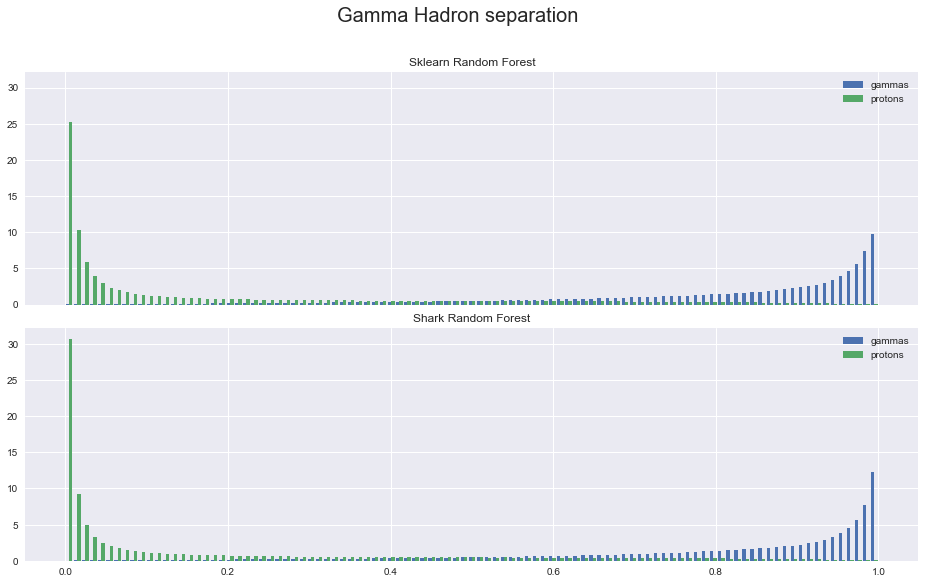

In [64]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True, figsize=(16, 9))
f.suptitle('Gamma Hadron separation', fontsize=20)

ax1.hist([rf_gprob[:,1], rf_pprob[:,1]], bins=101, label=['gammas', 'protons'], normed=True)
ax1.set_title('Sklearn Random Forest')
ax1.legend(loc='best')
ax2.hist([shark_gprob[:,1], shark_pprob[:,1]], bins=101, label=['gammas', 'protons'], normed=True)
ax2.set_title('Shark Random Forest')
ax2.legend(loc='best')

f.subplots_adjust(hspace=0.1)

### Q-factor and ROC curve
Q factor is widely used in astrophysics literature to measure the goodness of classification: it is measured as

$$Q = \frac{\varepsilon_{\gamma}}{\sqrt{\varepsilon_{p}}}$$

where $\varepsilon_{\gamma}$ is the fraction of **well classified gammas**, and $\varepsilon_{p}$ is the fraction of **badly classified protons** (false positives).
This is usually plotted against the *acceptance* (or *threshold*) for the probabilities.
Here's the code to have returned the Q factor as an array of values, having varied the acceptance.

In [16]:
def compute_Qfactor(g, p):
    import pandas as pd
    # tot number of gammas
    Ng = len(g)
    # of protons
    Np = len(p)

    # 102 edges -> 101 bins
    bins = np.linspace(0, 1, 102)

    # binning and cumsum for gammas
    gbins = pd.cut(g[:, 1], bins)
    gcount = gbins.value_counts()
    # reverse array
    gcount[:] = gcount.values[::-1].copy()
    g_cumsum = np.cumsum(gcount.values)
    # eps_g are normalised true positives (Tp)
    eps_g = g_cumsum / Ng

    # binning and cumsum for protons
    pbins = pd.cut(p[:, 1], bins)
    pcount = pbins.value_counts()
    # reverse array
    pcount[:] = pcount.values[::-1].copy()
    p_cumsum = np.cumsum(pcount.values)
    # eps_p are normalised false positives (Fp)
    eps_p = p_cumsum / Np

    Q = eps_g / np.sqrt(eps_p)
    Q[:] = Q[::-1].copy()

    return Q, bins, eps_g[::-1], eps_p[::-1]

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the **top left corner of the plot is the “ideal” point** - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it means that a larger area under the curve (**AUC**) is usually better.
The *steepness* of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.
The figure shows the ROC curve with the fraction of true positive gammas on y axis and the fraction of false positive gammas on x axis.
It can be seen that the two methods are somewhat equivalent, a direct measure being the score, namely the area under the curves.

In [14]:
def compute_roc_curve_scores_Qfactor(gprob, pprob, method=None, backup=None):
    """
    compute roc curve for the given method
    compute auscore, brier score loss and Q-factor
    Q-factor is to be plotted against threshold (as "confidence")
    :param gprob: predicted probabilities for gammas
    :param pprob: predicted probabilities for protons
    :param method: string, classification method
    :return: false positive gammas, true positive gammas, confidence, auc_score, Q-factor
    """
    from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss
    # prob is a 1-D array with predicted probabilities to be a gamma
    prob = np.hstack([gprob[:, 1], pprob[:, 1]])

    # tot number of gammas
    Ng = len(gprob)
    # of protons
    Np = len(pprob)

    tg = np.ones(Ng, dtype=np.uint8)
    tp = np.zeros(Np, dtype=np.uint8)
    truth = np.hstack([tg, tp])

    fpr, tpr, threshold = roc_curve(truth, prob, pos_label=1)
    auscore = roc_auc_score(truth, prob)
    brier = brier_score_loss(truth, prob)

    # Qfactor is to be plotted against threshold
    Qfactor, bins, eps_g, eps_p = compute_Qfactor(gprob, pprob)

    if backup:
        # backup everything
        np.savez_compressed('roc_curve_and_scores_' + str(method),
                            fpr=fpr, tpr=tpr, auscore=auscore, brier=brier, 
                            q=Qfactor, eps_g=eps_g, eps_p=eps_p)

    return fpr, tpr, bins, auscore, brier, Qfactor, threshold, eps_g, eps_p

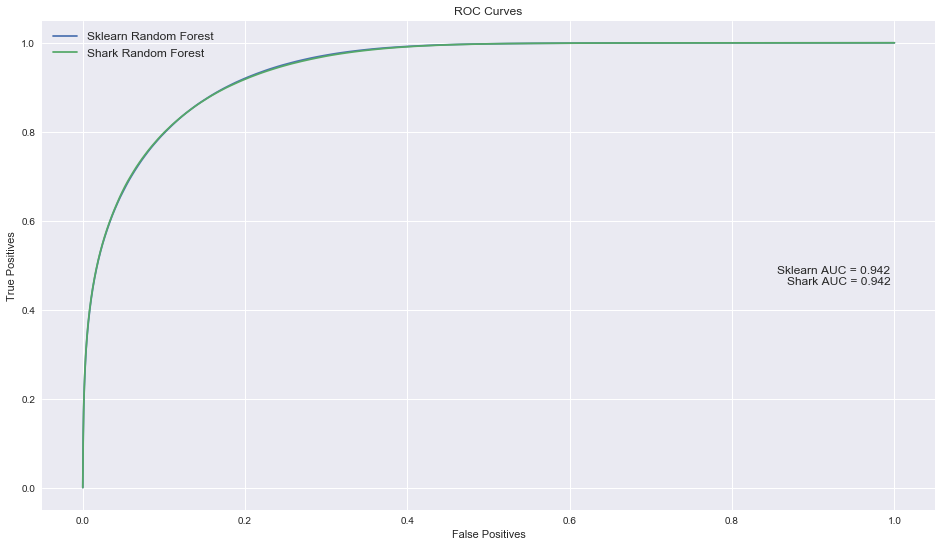

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

rf_fp, rf_tp, bins, rf_aus, __, rf_Qf, rf_thr = compute_roc_curve_scores_Qfactor(rf_gprob, rf_pprob)
sh_fp, sh_tp, __, sh_aus, __, sh_Qf, rf_thr = compute_roc_curve_scores_Qfactor(shark_gprob, shark_pprob)

fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title("ROC Curves")
ax.set_xlabel("False Positives")
ax.set_ylabel("True Positives")
ax.plot(rf_fp, rf_tp, label='Sklearn Random Forest')
ax.plot(sh_fp, sh_tp, label='Shark Random Forest')
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=12)
plt.text(0.95, 0.5, 'Sklearn AUC = {}\nShark AUC = {}'.format(np.round(rf_aus, 3), np.round(sh_aus, 3)), 
         ha='right', va='top', transform = ax.transAxes, fontsize=12)

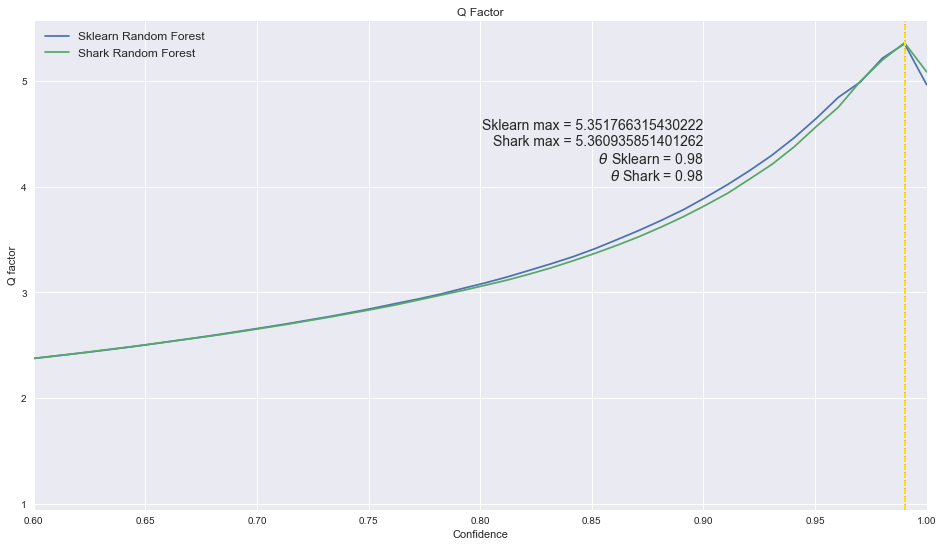

In [71]:
fig.clf()
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title("Q Factor")
ax.set_xlabel("Confidence")
ax.set_ylabel("Q factor")
ax.set_xlim(0.6, )
ax.plot(bins[1:], rf_Qf, label='Sklearn Random Forest')
ax.plot(bins[1:], sh_Qf, label='Shark Random Forest')
# ax.axhline(np.max(rf_Qf[0]), linestyle='dashed')
# ax.axhline(np.max(nn_Qf[0]), linestyle='dashed', color='green')
max_idx_sk = np.argmax(rf_Qf)
plt.axvline(bins[max_idx_sk + 1], linestyle='dashed', color='red')
max_idx_sh = np.argmax(sh_Qf)
plt.axvline(bins[max_idx_sh + 1], linestyle='dashed', color='yellow')

plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=12)
plt.text(0.75, 0.8, 'Sklearn max = {}\nShark max = {}\n \
'r'$\theta$'' Sklearn = {}\n'r'$\theta$'' Shark = {}'.format(np.max(rf_Qf), np.max(sh_Qf), 
                                                 np.round(bins[max_idx_sk], 2), np.round(bins[max_idx_sh], 2)), 
         ha='right', va='top', transform = ax.transAxes, fontsize=14)

### Precision Recall Curve
Precision-recall curves are typically used in binary classification to study the output of a classifier: precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

Precision $P$ is defined as the number of true positives $T_{p}$ over the number of true positives plus the number of false positives $F_{p}$.

$$P = \frac{T_{p}}{T_{p} + F_{p}}$$

$$R = \frac{T_{p}}{T_{p} + F_{n}}$$
> A system with *high recall but low precision* returns many results, but **most of its predicted labels are incorrect when compared to the training labels**. A system with *high precision but low recall* is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

To sum up, a low precision means many particles have been mis-labelled, while a low recall means many gammas have been classified as protons (and then lost!).

In [21]:
def compute_precision_recall_curve(gprob, pprob, method=None, backup=None):
    """
    compute precision recall curve with sklearn.metrics
    compute various scores:
    - precision 
    - recall 
    - f1
    - accuracy
    :param gprob: predicted probabilities for gammas
    :param pprob: predicted probabilities for protons
    :return: 
    """
    from sklearn.metrics import precision_recall_curve, average_precision_score
    # prob is a 1-D array with predicted probabilities to be a gamma
    prob = np.hstack([gprob[:, 1], pprob[:, 1]])

    tg = np.ones(len(gprob), dtype=np.uint8)
    tp = np.zeros(len(pprob), dtype=np.uint8)
    truth = np.hstack([tg, tp])

    precision, recall, threshold = precision_recall_curve(truth, prob, pos_label=1)
    average_precision = average_precision_score(truth, prob)

    if backup:
        np.savez_compressed('precision_recall_curve_' + str(method),
                            precision=precision, recall=recall, thr=threshold, avg_precision=average_precision)

    return precision, recall, threshold

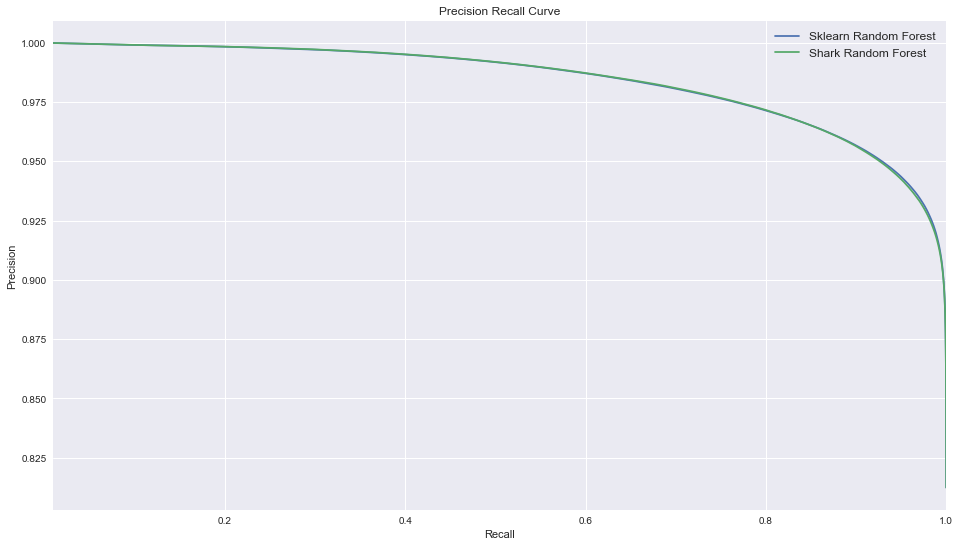

In [20]:
rf_prec, rf_recall, rf_thres = compute_precision_recall_curve(rf_gprob, rf_pprob)
sh_prec, sh_recall, sh_thres = compute_precision_recall_curve(shark_gprob, shark_pprob)

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn

# fig.clf()
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title("Precision Recall Curve")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_xlim(0.01, 1)
ax.plot(rf_recall, rf_prec, label='Sklearn Random Forest')
ax.plot(sh_recall, sh_prec, label='Shark Random Forest')
# plt.axvline(0.8, linestyle='dashed', color='red')
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=12)

### Comments
Easy said: `Shark` and `scikit-learn` seems to perform the same on this dataset. From the gamma-hadron separation plot, it seems `Shark` is able to better fill the edge bins, thus assigning probabilities close to $0$ (hadrons) and $1$ (gammas) to more individuals in the population. Other thing worth noting, `sklearn` is much **faster** in execution: the same dataset used for training the classifier object is run in minutes from the `Python` library, hours from `Shark`.

## Confusion Matrix for Sklearn Random Forest Classifier
From wikipedia:
> In the field of machine learning and specifically the problem of statistical classification, a confusion matrix, also known as an error matrix, is a specific table layout that allows visualization of the performance of an algorithm. The name stems from the fact that it makes it easy to see if the system is confusing two classes (i.e. commonly mislabelling one as another). 

Sounds useful!

The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

The `scikit-learn` functions operate on discrete labels (not probabilities), so I wrote a function to have these results **for each** threshold as defined for other metrics: `thresholds = np.linspace(0, 1, 102)`

In [2]:
def confusion_matrix_and_report(gprob, pprob, print_report=False):
    from sklearn.metrics import confusion_matrix, classification_report
    # have to assign int labels to predicted probabilities for each threshold

    thresholds = np.linspace(0, 1, 102)

    prob = np.hstack([gprob[:, 1], pprob[:, 1]])

    # matrix to store int probabilities, first index is threshold index
    int_prob = np.empty(shape=(len(thresholds) - 1, len(prob)))

    # build matrix of ints
    for i in range(len(thresholds) - 1):
        # int_prob[i] = [int(0) if x < thresholds[i + 1] else int(1) for x in prob]
        int_prob[i] = [int(1) if x >= thresholds[i] else int(0) for x in prob]

    tg = np.ones(len(gprob), dtype=np.uint8)
    tp = np.zeros(len(pprob), dtype=np.uint8)
    truth = np.hstack([tg, tp])

    tn = np.empty(shape=(len(thresholds) - 1)) # true negatives
    fp = np.empty(shape=(len(thresholds) - 1)) # false positives
    fn = np.empty(shape=(len(thresholds) - 1)) # false negatives
    tp = np.empty(shape=(len(thresholds) - 1)) # true positives
    cr = np.empty(shape=(len(thresholds) - 1), dtype=object) # classification reports
    cm = np.empty(shape=(len(thresholds) - 1), dtype=object) # confusion matrix

    for i in range(len(thresholds) - 1):
        cm[i] = confusion_matrix(truth, int_prob[i])
        # normalize confusion matrix
        cm[i] = cm[i].astype('float') / cm[i].sum(axis=1)[:, np.newaxis]
        # save tn and friends as array, to build normalized plots
        tn[i], fp[i], fn[i], tp[i] = cm[i].ravel()

    if print_report:
        target_names = ['protons', 'gammas']
        for i in range(len(thresholds) - 1):
            cr[i] = classification_report(truth, int_prob[i], target_names=target_names)

    np.savez_compressed('confusion_matrix_and_report.dat', tp=tp, fp=fp, fn=fn, tn=tn, cm=cm, cr=cr)

    return tp, fp, fn, tn, cm, cr

In [3]:
# Load data
with np.load('../gh_reconstruction/local_data/dc1/confusion_matrix_and_report_GEQ.dat.npz') as data:
    tp = data['tp']
    fp = data['fp']
    fn = data['fn']
    tn = data['tn']
    cm = data['cm']
    # The classification report "cr" is a short text showing the main classification metrics.
    cr = data['cr']

# Load tp and friends from compute_Qfactor
# __, __, tp, fp = compute_Qfactor(rf_gprob, rf_pprob)
# fn = 1.0 - tp
# tn = 1.0 - fp

First we plot normalized Precision and Recall against threshold (hence, gammaness):

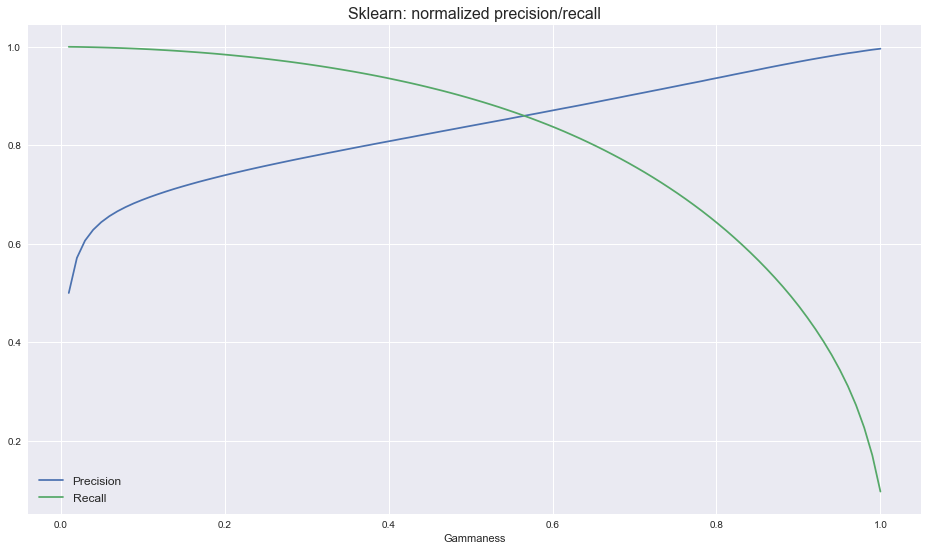

In [4]:
# generate thresholds
thresholds = np.linspace(0, 1, 102)

# Relative (normalized) Precision and Recall 
P = tp / (tp + fp)
R = tp / (tp + fn)

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn

fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title('Sklearn: normalized precision/recall', fontsize=16)
ax.plot(thresholds[1:], P,  label='Precision')
ax.plot(thresholds[1:], R,  label='Recall')
ax.set_xlabel('Gammaness')
# plt.axhline(0.8, linestyle='dashed', color='red')
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=12)

### Confusion matrix

Example of single (normalized) confusion matrix, where you have this structure:

In [5]:
np.matrix([['True negatives', 'False positives'], ['False negatives', 'True positives']])

matrix([['True negatives', 'False positives'],
        ['False negatives', 'True positives']], 
       dtype='<U15')

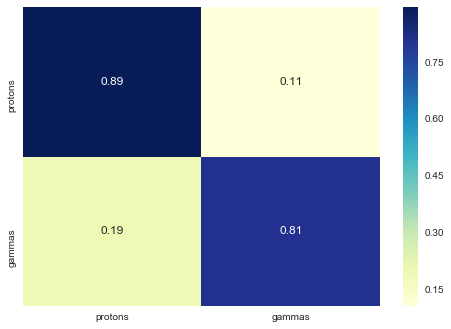

In [6]:
seaborn.heatmap(cm[64], cmap="YlGnBu", annot=True, xticklabels=['protons', 'gammas'], 
                yticklabels=['protons', 'gammas'])

Next I plot confusion matrixes for 50 values of gammaness.
Each matrix has its relative gammaness in the title, just remember the matrix structure:

['True negatives', 'False positives']

['False negatives', 'True positives']

/usr/local/opt/anaconda3/envs/idp/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


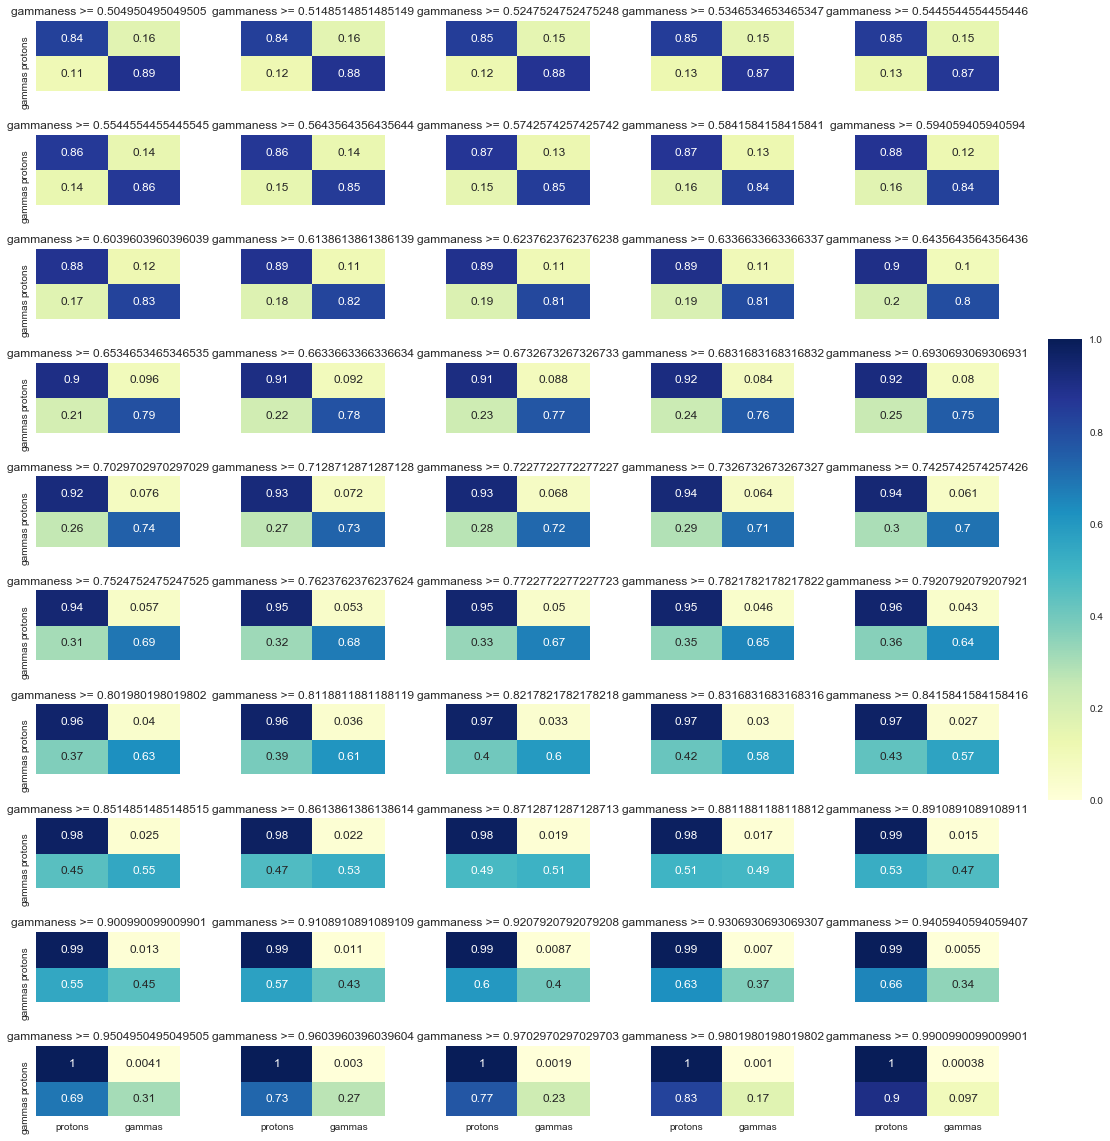

In [8]:
fig, axn = plt.subplots(10, 5, sharex=True, sharey=True, figsize=(16, 16))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
thresholds = np.linspace(0, 1, 102)

for i, ax in enumerate(axn.flat):
    index = i+51
    ax.set_title('gammaness >= {}'.format(thresholds[index]))
    tn[i], fp[i], fn[i], tp[i] = cm[index].ravel()
    seaborn.heatmap(cm[index], cmap="YlGnBu", ax=ax,
                    annot=True, xticklabels=['protons', 'gammas'], 
                    yticklabels=['protons', 'gammas'], cbar=i == 0,
                    vmin=0, vmax=1,
                    cbar_ax=None if i else cbar_ax)

fig.tight_layout(rect=[0, 0, .9, 1])

Some interpretations:
- from a gammaness value of `~64%` on, you start to throw away more than `20%` of true gammas: this can be useful to know for if you need a proper amount of gammas to perform some scientific analysis (DL4 data);
- `Q-factor` is `max` at `gammaness > 98%`; this is because $\sqrt{f_{p}}$ (**false positives, background, protons classified as gammas**) are the denominator of the `Q-factor` and its value become very small as gammaness increase. The countereffect is for those values you are wasting `~80%` of gammas.


## Other Classifiers
Same input data have been passed through other machine learning methods, namely:
- Extra Random Trees
- Multi Layer Perceptron (Neural Network)

About Multi Layer Perceptron (Neural Network): it's been used a shallow network with 20 neurons in an only hidden layer, after a number of tests with two hidden layers and varying the number of neurons also: this shallow network gives the best result on this dataset. 

### Gamma Hadron separation

In [9]:
# with np.load('local_data/dc1/gh_probs_bayes.dat.npz') as data:
#     bay_gprob = data['g']
#     bay_pprob = data['p']

with np.load('../gh_reconstruction/local_data/dc1/gh_probs_dnn.dat.npz') as data:
    nn_gprob = data['g']
    nn_pprob = data['p']
    
with np.load('../gh_reconstruction/local_data/dc1/gh_probs_extra.dat.npz') as data:
    ex_gprob = data['g']
    ex_pprob = data['p']
    
assert nn_gprob.shape == ex_gprob.shape #== bay_gprob.shape

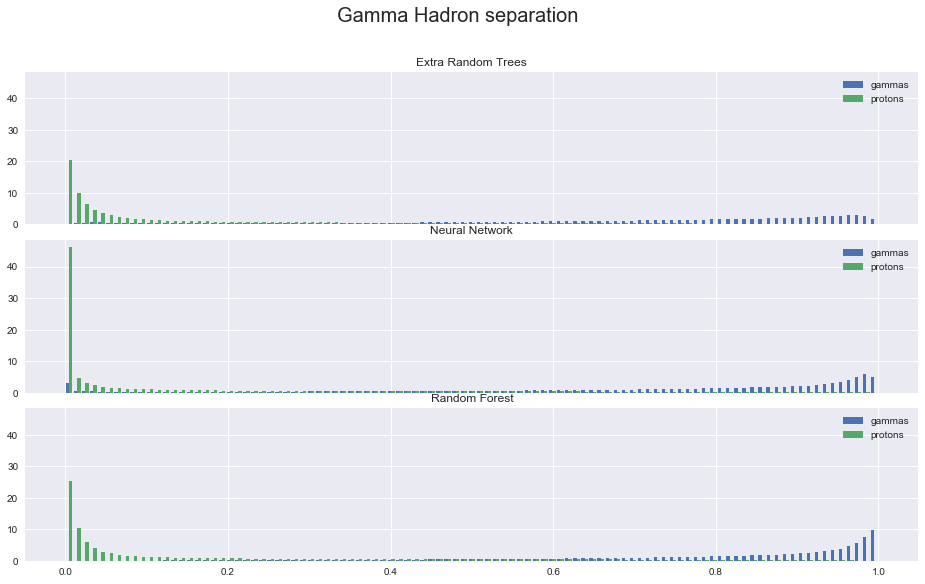

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn

f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(16, 9))
f.suptitle('Gamma Hadron separation', fontsize=20)

# b = np.linspace(0, 1, 100)

ax1.hist([ex_gprob[:,1], ex_pprob[:,1]], bins=101, label=['gammas', 'protons'], normed=True)
ax1.set_title('Extra Random Trees')
ax1.legend(loc='best')
ax2.hist([nn_gprob[:,1], nn_pprob[:,1]], bins=101, label=['gammas', 'protons'], normed=True)
ax2.set_title('Neural Network')
ax2.legend(loc='best')
ax3.hist([rf_gprob[:,1], rf_pprob[:,1]], bins=101, label=['gammas', 'protons'], normed=True)
ax3.set_title('Random Forest')
ax3.legend(loc='best')

f.subplots_adjust(hspace=0.1)

### ROC curve

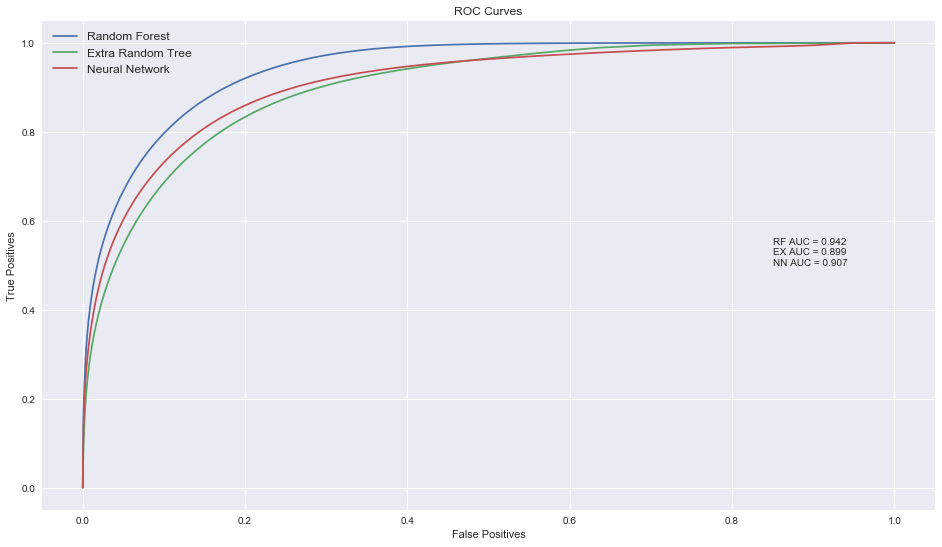

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

rf_fp, rf_tp, bins, rf_aus, __, rf_Qf, rf_thr, __, __ = compute_roc_curve_scores_Qfactor(rf_gprob, rf_pprob)
ex_fp, ex_tp, bins, ex_aus, __, ex_Qf, ex_thr, __, __ = compute_roc_curve_scores_Qfactor(ex_gprob, ex_pprob)
nn_fp, nn_tp, __, nn_aus, __, nn_Qf, nn_thr, __, __ = compute_roc_curve_scores_Qfactor(nn_gprob, nn_pprob)
#bay_fp, bay_tp, __, bay_aus, __, bay_Qf, bay_thr, __, __ = compute_roc_curve_scores_Qfactor(bay_gprob, bay_pprob)

fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title("ROC Curves")
ax.set_xlabel("False Positives")
ax.set_ylabel("True Positives")
ax.plot(rf_fp, rf_tp, label='Random Forest')
ax.plot(ex_fp, ex_tp, label='Extra Random Tree')
ax.plot(nn_fp, nn_tp, label='Neural Network')
#ax.plot(bay_fp, bay_tp, label='Naive Bayes')
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=12)
plt.text(0.85, 0.5, 'RF AUC = {}\nEX AUC = {}\nNN AUC = {}'.format(np.round(rf_aus, 3), 
                                                                                 np.round(ex_aus, 3), 
                                                                                 np.round(nn_aus, 3), 
         ha='right', va='top', transform = ax.transAxes, fontsize=22))

### Q-factor plot

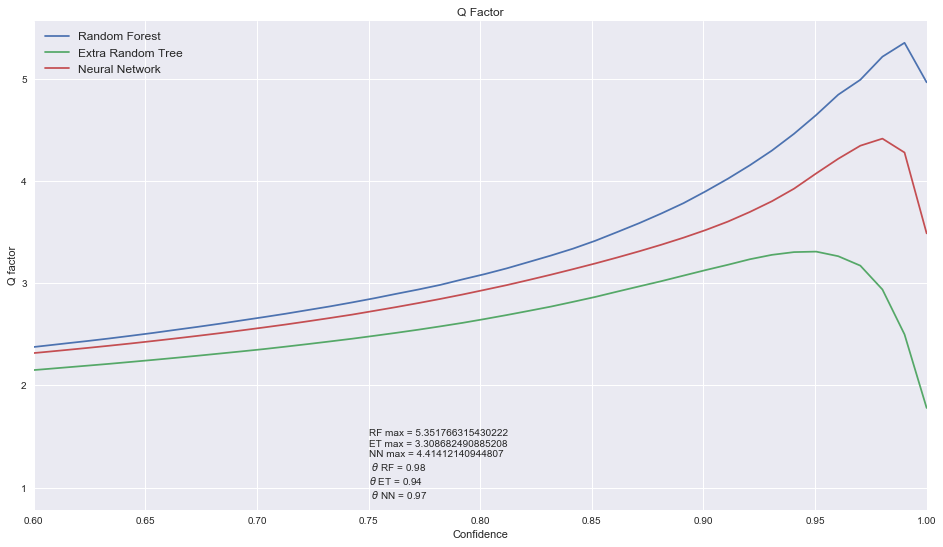

In [19]:
fig.clf()
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title("Q Factor")
ax.set_xlabel("Confidence")
ax.set_ylabel("Q factor")
ax.set_xlim(0.6, )
ax.plot(bins[1:], rf_Qf, label='Random Forest')
ax.plot(bins[1:], ex_Qf, label='Extra Random Tree')
ax.plot(bins[1:], nn_Qf, label='Neural Network')
# ax.plot(bins[1:], bay_Qf, label='Naive Bayes')
# ax.axhline(np.max(rf_Qf[0]), linestyle='dashed')
# ax.axhline(np.max(nn_Qf[0]), linestyle='dashed', color='green')
max_idx_sk = np.argmax(rf_Qf)
# plt.axvline(bins[max_idx_sk + 1], linestyle='dashed', color='red')
max_idx_ex = np.argmax(ex_Qf)
# plt.axvline(bins[max_idx_ex + 1], linestyle='dashed', color='yellow')
max_idx_nn = np.argmax(nn_Qf)

plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=12)
plt.text(0.75, 0.9, 'RF max = {}\nET max = {}\nNN max = {}\n \
'r'$\theta$'' RF = {}\n'r'$\theta$'' ET = {}\n \
'r'$\theta$'' NN = {}'.format(np.max(rf_Qf), np.max(ex_Qf),
                                                      np.max(nn_Qf),
                                                      np.round(bins[max_idx_sk], 2), np.round(bins[max_idx_ex], 2), 
                                                      np.round(bins[max_idx_nn], 2), 
         ha='right', va='top', transform = ax.transAxes, fontsize=14))

### Precision Recall

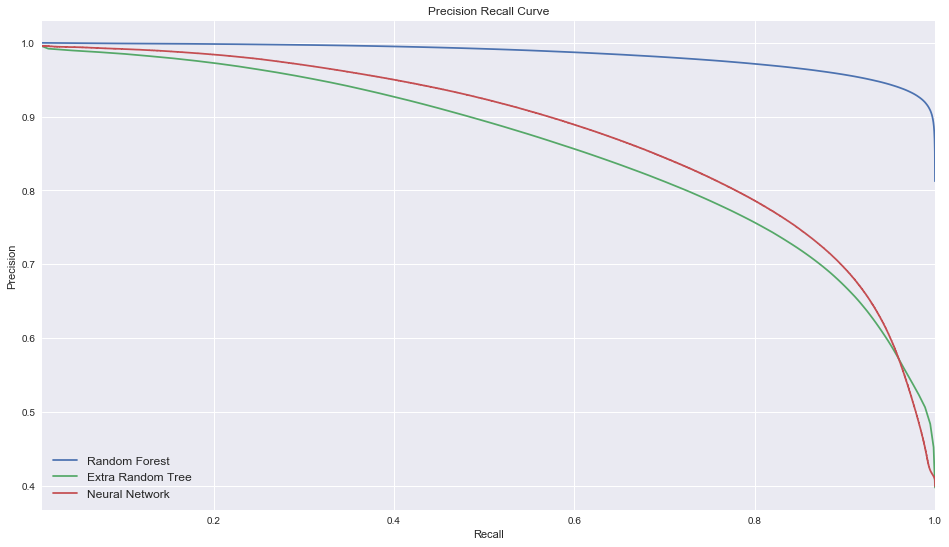

In [22]:
rf_prec, rf_recall, __ = compute_precision_recall_curve(rf_gprob, rf_pprob)
ex_prec, ex_recall, __ = compute_precision_recall_curve(ex_gprob, ex_pprob)
nn_prec, nn_recall, __ = compute_precision_recall_curve(nn_gprob, nn_pprob)
# bay_prec, bay_recall, __ = compute_precision_recall_curve(bay_gprob, bay_pprob)

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn

# fig.clf()
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title("Precision Recall Curve")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_xlim(0.01, 1)
ax.plot(rf_recall, rf_prec, label='Random Forest')
ax.plot(ex_recall, ex_prec, label='Extra Random Tree')
ax.plot(nn_recall, nn_prec, label='Neural Network')
# ax.plot(bay_recall, bay_prec, label='Naive Bayes')
# plt.axvline(0.8, linestyle='dashed', color='red')
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=12)

Random Forest leads all over the way

## Energy reconstruction
This is ongoing, so far I can measure performances with traditional scores from `scikit-learn`.

In [23]:
with np.load("../gh_reconstruction/local_data/energies_and_metricsrf.npz") as data:
    en_reco = data['predicted']
    en_true = data['true']

In [24]:
def regression_metrics(true, pred):
    from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score

    r2 = r2_score(true, pred)
    mae = mean_absolute_error(true, pred)
    mse = mean_squared_error(true, pred)
    evs = explained_variance_score(true, pred)
    
    return r2, mae, mse, evs

In [25]:
r2, mae, mse, evs = regression_metrics(en_true, en_reco)
print("R2 score: {}\nMean Absolute Error: {}\nMean Squared Error: {}\nExplained Variance Score: {}\n".format(r2, 
                                                                                                            mae,
                                                                                                            mse,
                                                                                                            evs))

R2 score: 0.86880657860331
Mean Absolute Error: 3.6838500453554484
Mean Squared Error: 90.21653978801926
Explained Variance Score: 0.8689813539430391

